This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/acrobot.html).  I recommend having both windows open, side-by-side!


In [1]:
import math

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    RobotDiagramBuilder,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    namedview,
)
from pydrake.examples import (
    AcrobotGeometry,
    AcrobotInput,
    AcrobotPlant,
    AcrobotState,
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)
from pydrake.solvers import MathematicalProgram, Solve

from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer
from underactuated.scenarios import AddFloatingRpyJoint

if running_as_notebook:
    mpld3.enable_notebook()

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Dynamics of the Acrobot

The acrobot is a core example in Drake.  We could certainly load it from a .urdf file, but Drake offers an Acrobot implementation that makes it convenient to manipulate the parameters (and visualize the system with different parameters).

In [3]:
def acrobot_demo():
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    # Setup visualization
    scene_graph = builder.AddSystem(SceneGraph())
    AcrobotGeometry.AddToBuilder(
        builder, acrobot.get_output_port(0), scene_graph
    )
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # Setup slider input
    meshcat.AddSlider("u", min=-5, max=5, step=0.1, value=0.0)
    torque_system = builder.AddSystem(MeshcatSliders(meshcat, ["u"]))
    builder.Connect(torque_system.get_output_port(), acrobot.get_input_port())

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Set the initial conditions (theta1, theta2, theta1dot, theta2dot)
    context.SetContinuousState([1, 0, 0, 0])

    if running_as_notebook:  # Then we're not just running as a test on CI.
        simulator.set_target_realtime_rate(1.0)

        print("Use the slider in the MeshCat controls to apply elbow torque.")
        print("Press 'Stop Simulation' in MeshCat to continue.")
        meshcat.AddButton("Stop Simulation")
        while meshcat.GetButtonClicks("Stop Simulation") < 1:
            simulator.AdvanceTo(simulator.get_context().get_time() + 1.0)
    else:
        simulator.AdvanceTo(0.1)

    meshcat.DeleteAddedControls()


acrobot_demo()

Use the slider in the MeshCat controls to apply elbow torque.
Press 'Stop Simulation' in MeshCat to continue.


# Dynamics of the Cart-Pole

In [4]:
def cartpole_demo():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.AddModelsFromUrl("package://underactuated/models/cartpole.urdf")
    plant.Finalize()

    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # Setup slider input
    meshcat.AddSlider("u", min=-30.0, max=30, step=0.1, value=0.0)
    force_system = builder.AddSystem(MeshcatSliders(meshcat, ["u"]))
    builder.Connect(
        force_system.get_output_port(), plant.get_actuation_input_port()
    )

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Set the initial conditions (x, theta, xdot, thetadot)
    context.SetContinuousState([0, 1, 0, 0])

    if running_as_notebook:  # Then we're not just running as a test on CI.
        simulator.set_target_realtime_rate(1.0)

        print("Use the slider in the MeshCat controls to apply elbow torque.")
        print("Press 'Stop Simulation' in MeshCat to continue.")
        meshcat.AddButton("Stop Simulation")
        while meshcat.GetButtonClicks("Stop Simulation") < 1:
            simulator.AdvanceTo(simulator.get_context().get_time() + 1.0)
    else:
        simulator.AdvanceTo(0.1)

    meshcat.DeleteAddedControls()


cartpole_demo()

Use the slider in the MeshCat controls to apply elbow torque.
Press 'Stop Simulation' in MeshCat to continue.


# LQR for the Acrobot

First let's check the controllability.  Recall that the rank of the matrix is the number of of non-zero singular values.  So seeing very small singular values suggests "weak" controllability.

In [5]:
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.0)
    state.set_theta1dot(0.0)
    state.set_theta2dot(0.0)
    return state


def acrobot_controllability():
    acrobot = AcrobotPlant()
    context = acrobot.CreateDefaultContext()

    input = AcrobotInput()
    input.set_tau(0.0)
    acrobot.get_input_port(0).FixValue(context, input)

    context.get_mutable_continuous_state_vector().SetFromVector(
        UprightState().CopyToVector()
    )

    linearized_acrobot = Linearize(acrobot, context)
    print(
        f"The singular values of the controllability matrix are: {np.linalg.svd(ControllabilityMatrix(linearized_acrobot), compute_uv=False)}"
    )


acrobot_controllability()

The singular values of the controllability matrix are: [5.11718692e+02 1.23084288e+02 8.06819874e-02 7.15326677e-02]


In [16]:
def acrobot_balancing_example():
    def BalancingLQR():
        # Design an LQR controller for stabilizing the Acrobot around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original AcrobotState coordinates).

        acrobot = AcrobotPlant()
        context = acrobot.CreateDefaultContext()

        input = AcrobotInput()
        input.set_tau(0.0)
        acrobot.get_input_port(0).FixValue(context, input)

        context.get_mutable_continuous_state_vector().SetFromVector(
            UprightState().CopyToVector()
        )

        Q = np.diag((0.0, 10.0, 100.0, 100.0))
        R = [1]

        return LinearQuadraticRegulator(acrobot, context, Q, R)

    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2.0 * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(BalancingLQR())
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(
        controller.get_output_port(0), saturation.get_input_port(0)
    )

    # Setup visualization
    scene_graph = builder.AddSystem(SceneGraph())
    AcrobotGeometry.AddToBuilder(
        builder, acrobot.get_output_port(0), scene_graph
    )
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    duration = 4.0 if running_as_notebook else 0.1
    for i in range(5):
        context.SetTime(0.0)
        context.SetContinuousState(
            UprightState().CopyToVector()
            + 0.05
            * np.random.randn(
                4,
            )
        )
        simulator.Initialize()
        simulator.AdvanceTo(duration)


acrobot_balancing_example()

# LQR for the Cart-Pole

In [12]:
def cartpole_balancing_example():
    def UprightState():
        state = (0, np.pi, 0, 0)
        return state

    def Controllability(plant):
        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])
        plant.SetPositionsAndVelocities(context, UprightState())

        linearized_plant = Linearize(
            plant,
            context,
            input_port_index=plant.get_actuation_input_port().get_index(),
            output_port_index=plant.get_state_output_port().get_index(),
        )
        print(linearized_plant.A())
        print(linearized_plant.B())
        print(
            f"The singular values of the controllability matrix are: {np.linalg.svd(ControllabilityMatrix(linearized_plant), compute_uv=False)}"
        )

    def BalancingLQR(plant):
        # Design an LQR controller for stabilizing the CartPole around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original CartPole coordinates).

        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])

        plant.SetPositionsAndVelocities(context, UprightState())

        Q = np.diag((1.0, 0.0, 10.0, 10.0))
        R = np.array([1])

        # MultibodyPlant has many (optional) input ports, so we must pass the
        # input_port_index to LQR.
        return LinearQuadraticRegulator(
            plant,
            context,
            Q,
            R,
            input_port_index=plant.get_actuation_input_port().get_index(),
        )

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.AddModelsFromUrl("package://underactuated/models/cartpole.urdf")
    plant.Finalize()

    controller = builder.AddSystem(BalancingLQR(plant))
    builder.Connect(
        plant.get_state_output_port(), controller.get_input_port(0)
    )
    builder.Connect(
        controller.get_output_port(0), plant.get_actuation_input_port()
    )

    # Setup visualization
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyMutableContextFromRoot(context)

    # Simulate
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    duration = 5.0 if running_as_notebook else 0.1
    for i in range(5):
        context.SetTime(0.0)
        plant.SetPositionsAndVelocities(
            plant_context,
            UprightState()
            + 0.1
            * np.random.randn(
                4,
            ),
        )
        simulator.Initialize()
        simulator.AdvanceTo(duration)


np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})
cartpole_balancing_example()

# LQR for the Planar Quadrotor

In [8]:
def planar_quadrotor_example():
    def QuadrotorLQR(plant):
        context = plant.CreateDefaultContext()
        context.SetContinuousState(np.zeros([6, 1]))
        plant.get_input_port(0).FixValue(
            context, plant.mass * plant.gravity / 2.0 * np.array([1, 1])
        )

        Q = np.diag([10, 10, 10, 1, 1, (plant.length / 2.0 / np.pi)])
        R = np.array([[0.1, 0.05], [0.05, 0.1]])

        return LinearQuadraticRegulator(plant, context, Q, R)

    builder = DiagramBuilder()
    plant = builder.AddSystem(Quadrotor2D())

    controller = builder.AddSystem(QuadrotorLQR(plant))
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Setup visualization
    visualizer = builder.AddSystem(Quadrotor2DVisualizer(show=False))
    builder.Connect(plant.get_output_port(0), visualizer.get_input_port(0))

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    duration = 4.0 if running_as_notebook else 0.1
    visualizer.start_recording()
    print("simulating...")
    for i in range(5):
        context.SetTime(0.0)
        context.SetContinuousState(
            np.random.randn(
                6,
            )
        )
        simulator.Initialize()
        simulator.AdvanceTo(duration)
    print("done.\ngenerating animation...")
    ani = visualizer.get_recording_as_animation()
    display(HTML(ani.to_jshtml()))


planar_quadrotor_example()

simulating...
done.
generating animation...


# LQR for the 3D Quadrotor

Art assets courtesy of our friends at Skydio.

In [10]:
def quadrotor_example():
    builder = DiagramBuilder()

    plant = builder.AddSystem(QuadrotorPlant())

    controller = builder.AddSystem(StabilizingLQRController(plant, [0, 0, 1]))
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Set up visualization in MeshCat
    scene_graph = builder.AddSystem(SceneGraph())
    QuadrotorGeometry.AddToBuilder(
        builder, plant.get_output_port(0), scene_graph
    )
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty("/Background", "visible", False)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # end setup for visualization

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    context = simulator.get_mutable_context()

    # Simulate
    for i in range(5):
        context.SetTime(0.0)
        context.SetContinuousState(
            0.5
            * np.random.randn(
                12,
            )
        )
        simulator.Initialize()
        simulator.AdvanceTo(4.0 if running_as_notebook else 0.1)


quadrotor_example()

## The 3D Quadrotor again, now using MultibodyPlant

The example above used [`QuadrotorPlant`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1examples_1_1quadrotor_1_1_quadrotor_plant.html), in which I've typed in the equations of motion by hand.  This is a great way to work with the system, but is hard to generalize.

If you want to add additional forces to the model -- for instance if you want the quadrotor to have contact dynamics with the world (to land on the ground, or collide with a tree) or if you want to add e.g. wind -- then we need a more general solution.  We can also implement the quadrotor dynamics using `MultibodyPlant`.  We just need to manually wire the [`Propeller`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_propeller.html) forces into the `Diagram` (because `Propeller` is not a concept supported in URDF nor SDF just yet).

In [18]:

def MakeMultibodyQuadrotor():
    builder = DiagramBuilder()
    # The MultibodyPlant handles f=ma, but doesn't know about propellers.
    plant = builder.AddSystem(MultibodyPlant(0.0))
    parser = Parser(plant)
    (model_instance,) = parser.AddModelsFromUrl(
        "package://drake/examples/quadrotor/quadrotor.urdf"
    )
    # By default the multibody has a quaternion floating base.  To match
    # QuadrotorPlant, we can manually add a FloatingRollPitchYaw joint. We set
    # `use_ball_rpy` to false because the BallRpyJoint uses angular velocities
    # instead of ṙ, ṗ, ẏ.
    AddFloatingRpyJoint(
        plant,
        plant.GetFrameByName("base_link"),
        model_instance,
        use_ball_rpy=False,
    )
    plant.Finalize()

    # Now we can add in propellers as an external force on the MultibodyPlant.
    body_index = plant.GetBodyByName("base_link").index()
    # Default parameters from quadrotor_plant.cc:
    L = 0.15  # Length of the arms (m).
    kF = 1.0  # Force input constant.
    kM = 0.0245  # Moment input constant.

    # Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
    prop_info = [
        PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    propellers = builder.AddSystem(Propeller(prop_info))
    builder.Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )
    builder.Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )
    builder.ExportInput(propellers.get_command_input_port(), "u")

    return builder.Build(), plant


# This test demonstrates that the MultibodyPlant version has identical dynamics
# to the QuadrotorPlant version (except that the state variables are permuted).
# TODO(russt): Move this to Drake as a unit test.
def MultibodyQuadrotorExample():
    mbp_plant, mbp = MakeMultibodyQuadrotor()

    hand_derived_plant = QuadrotorPlant()

    # Compare the dynamics at a handful of states.
    mbp_plant_context = mbp_plant.CreateDefaultContext()
    mbp_context = mbp.GetMyContextFromRoot(mbp_plant_context)
    hand_derived_context = hand_derived_plant.CreateDefaultContext()

    # Permute mbp <=> hand_derived states.
    P = np.array(
        [
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 1],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 1, 0, 0],
        ]
    )
    PP = np.block([[P, np.zeros((6, 6))], [np.zeros((6, 6)), P]])

    rng = np.random.default_rng(seed=1037)
    for i in range(5):
        u = rng.random((4,))
        mbp_x = rng.random((12,))
        mbp_plant.get_input_port().FixValue(mbp_plant_context, u)
        mbp_context.SetContinuousState(mbp_x)
        mbp_xdot = mbp_plant.EvalTimeDerivatives(
            mbp_plant_context
        ).CopyToVector()

        hand_derived_x = PP @ mbp_x
        hand_derived_plant.get_input_port().FixValue(hand_derived_context, u)
        hand_derived_context.SetContinuousState(hand_derived_x)
        hand_derived_xdot = (
            PP
            @ hand_derived_plant.EvalTimeDerivatives(
                hand_derived_context
            ).CopyToVector()
        )

        assert np.allclose(
            mbp_xdot, hand_derived_xdot
        ), f"\nmbp\t\t = {mbp_xdot}\nhand_derived\t = {hand_derived_xdot}"


MultibodyQuadrotorExample()

Now we can use this in LQR and all of our other tools...

In [19]:
def MultibodyQuadrotorLQR():
    quadrotor, mbp = MakeMultibodyQuadrotor()
    # We'll use a namedview to make it easier to work with the state.
    StateView = namedview("state", mbp.GetStateNames(False))

    # Create the LQR controller
    context = quadrotor.CreateDefaultContext()
    nominal_state = StateView.Zero()
    nominal_state.z_x = 1.0  # height is 1.0m
    context.SetContinuousState(nominal_state[:])
    mass = mbp.CalcTotalMass(mbp.GetMyContextFromRoot(context))
    gravity = mbp.gravity_field().gravity_vector()[2]
    nominal_input = [-mass * gravity / 4] * 4
    quadrotor.get_input_port().FixValue(context, nominal_input)
    Q = np.diag(np.concatenate(([10] * 6, [1] * 6)))
    R = np.eye(4)
    controller = LinearQuadraticRegulator(quadrotor, context, Q, R)


MultibodyQuadrotorLQR()

# Multiple quadrotors

We've had a number of great projects over the years using multiple quadrotors. Here's a simple example of running LQR on multiple quadrotors simultaneously.  One could also do this by having two separate LQR controllers, both feeding into the propellors, but the wiring on this version is clean and simple.

In [20]:
def MakeMultipleQuadrotors():
    # The RobotDiagram is a convenient way to work with a MultibodyPlant +
    # SceneGraph.
    builder = RobotDiagramBuilder()
    plant = builder.plant()

    directives = """
    directives:
    - add_model:
        name: quad1
        file: package://drake/examples/quadrotor/quadrotor.urdf
    - add_model:
        name: quad2
        file: package://drake/examples/quadrotor/quadrotor.urdf
    """

    builder.parser().SetAutoRenaming(True)
    builder.parser().AddModelsFromString(directives, ".dmd.yaml")
    # Floating joints are easier for LQR.
    quad1 = plant.GetModelInstanceByName("quad1")
    AddFloatingRpyJoint(plant,
                        plant.GetFrameByName("base_link", quad1),
                        quad1,
                        use_ball_rpy=False)
    quad2 = plant.GetModelInstanceByName("quad2")
    AddFloatingRpyJoint(plant,
                        plant.GetFrameByName("base_link", quad2),
                        quad2,
                        use_ball_rpy=False)

    plant.Finalize()

    # Now we can add in propellers as an external force on the MultibodyPlant.
    quad1_body = plant.GetBodyByName("base_link", quad1).index()
    quad2_body = plant.GetBodyByName("base_link", quad2).index()
    # Default parameters from quadrotor_plant.cc:
    L = 0.15  # Length of the arms (m).
    kF = 1.0  # Force input constant.
    kM = 0.0245  # Moment input constant.

    # Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
    prop_info = [
        PropellerInfo(quad1_body, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(quad1_body, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(quad1_body, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(quad1_body, RigidTransform([0, -L, 0]), kF, -kM),
        PropellerInfo(quad2_body, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(quad2_body, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(quad2_body, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(quad2_body, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    propellers = builder.builder().AddSystem(Propeller(prop_info))
    builder.builder().Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )
    builder.builder().Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )
    builder.builder().ExportInput(propellers.get_command_input_port(), "u")
    builder.builder().ExportOutput(plant.get_state_output_port(), "x")
    builder.builder().ExportOutput(
        builder.scene_graph().get_query_output_port(), "query")

    return builder.Build()

def MultipleQuadrotorDemo():
    builder = DiagramBuilder()
    robot_diagram = builder.AddSystem(MakeMultipleQuadrotors())
    plant = robot_diagram.plant()

    # We'll use a namedview to make it easier to work with the state.
    StateView = namedview("state",
                          plant.GetStateNames(add_model_instance_prefix=True))
    x0 = StateView.Zero()
    x0.quad1_x_x = -1
    x0.quad1_z_x = 1
    x0.quad2_x_x = 1
    x0.quad2_z_x = 1
    plant.SetDefaultPositions(x0[:plant.num_positions()])

    # Create the LQR controller
    robot_diagram_context = robot_diagram.CreateDefaultContext()
    mass = plant.CalcTotalMass(
        plant.GetMyContextFromRoot(robot_diagram_context),
        [plant.GetModelInstanceByName("quad1")])
    gravity = plant.gravity_field().gravity_vector()[2]
    nominal_input = [-mass * gravity / 4] * 8
    robot_diagram.get_input_port().FixValue(robot_diagram_context,
                                            nominal_input)
    Q = np.diag(np.concatenate(([10] * 12, [1] * 12)))
    R = np.eye(8)
    print(robot_diagram_context)
    controller = builder.AddSystem(
        LinearQuadraticRegulator(robot_diagram, robot_diagram_context, Q, R))
    builder.Connect(controller.get_output_port(),
                    robot_diagram.get_input_port())
    builder.Connect(robot_diagram.GetOutputPort("x"),
                    controller.get_input_port())

    MeshcatVisualizer.AddToBuilder(builder,
                                   robot_diagram.GetOutputPort("query"),
                                   meshcat)
    diagram = builder.Build()

    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    context = simulator.get_mutable_context()

    # Simulate
    for i in range(5):
        context.SetTime(0.0)
        context.SetContinuousState(
            0.5
            * np.random.randn(
                24,
            )
        )
        simulator.Initialize()
        simulator.AdvanceTo(4.0 if running_as_notebook else 0.1)


MultipleQuadrotorDemo()

::drake/planning/RobotDiagram@0000000004700fc0 Context (of a Diagram)
----------------------------------------------------------------------
24 total continuous states
130 total numeric parameters in 13 groups
14 total abstract parameters

::drake/planning/RobotDiagram@0000000004700fc0::plant Context
--------------------------------------------------------------
Time: 0
States:
  24 continuous states
    -1  0  1  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

Parameters:
  13 numeric parameter groups with
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
                      0.775                    0                    0                    0 0.001935483870967742 0.003225806451612903 0.004516129032258064                    0                    0                    0
     10 parameters
                      0.775                    0                    0                    0 0.001935483870967742 0.003225806451612903 0.0045161290322580

# Differential Flatness

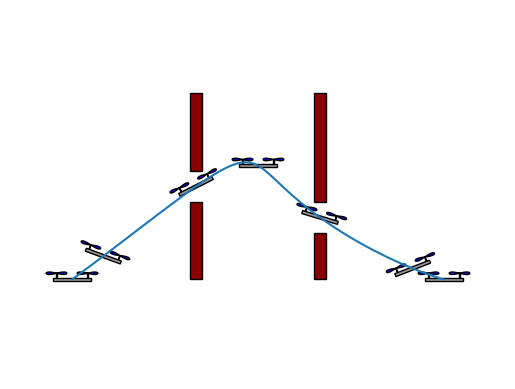

In [21]:
# TODO(russt): Use drake.trajectories.PiecewisePolynomialTrajectory
#  instead (currently missing python bindings for the required constructor),
#  or port this class to C++.
class PPTrajectory:
    def __init__(self, sample_times, num_vars, degree, continuity_degree):
        self.sample_times = sample_times
        self.n = num_vars
        self.degree = degree

        self.prog = MathematicalProgram()
        self.coeffs = []
        for i in range(len(sample_times)):
            self.coeffs.append(
                self.prog.NewContinuousVariables(num_vars, degree + 1, "C")
            )
        self.result = None

        # Add continuity constraints
        for s in range(len(sample_times) - 1):
            trel = sample_times[s + 1] - sample_times[s]
            coeffs = self.coeffs[s]
            for var in range(self.n):
                for deg in range(continuity_degree + 1):
                    # Don't use eval here, because I want left and right
                    # values of the same time
                    left_val = 0
                    for d in range(deg, self.degree + 1):
                        left_val += (
                            coeffs[var, d]
                            * np.power(trel, d - deg)
                            * math.factorial(d)
                            / math.factorial(d - deg)
                        )
                    right_val = self.coeffs[s + 1][var, deg] * math.factorial(
                        deg
                    )
                    self.prog.AddLinearConstraint(left_val == right_val)

        # Add cost to minimize highest order terms
        for s in range(len(sample_times) - 1):
            self.prog.AddQuadraticCost(
                np.eye(num_vars),
                np.zeros((num_vars, 1)),
                self.coeffs[s][:, -1],
            )

    def eval(self, t, derivative_order=0):
        if derivative_order > self.degree:
            return 0

        s = 0
        while s < len(self.sample_times) - 1 and t >= self.sample_times[s + 1]:
            s += 1
        trel = t - self.sample_times[s]

        if self.result is None:
            coeffs = self.coeffs[s]
        else:
            coeffs = self.result.GetSolution(self.coeffs[s])

        deg = derivative_order
        val = 0 * coeffs[:, 0]
        for var in range(self.n):
            for d in range(deg, self.degree + 1):
                val[var] += (
                    coeffs[var, d]
                    * np.power(trel, d - deg)
                    * math.factorial(d)
                    / math.factorial(d - deg)
                )

        return val

    def add_constraint(self, t, derivative_order, lb, ub=None):
        """Adds a constraint of the form d^deg lb <= x(t) / dt^deg <= ub."""
        if ub is None:
            ub = lb

        assert derivative_order <= self.degree
        val = self.eval(t, derivative_order)
        self.prog.AddLinearConstraint(val, lb, ub)

    def generate(self):
        self.result = Solve(self.prog)
        assert self.result.is_success()


tf = 3
zpp = PPTrajectory(
    sample_times=np.linspace(0, tf, 6),
    num_vars=2,
    degree=5,
    continuity_degree=4,
)
zpp.add_constraint(t=0, derivative_order=0, lb=[0, 0])
zpp.add_constraint(t=0, derivative_order=1, lb=[0, 0])
zpp.add_constraint(t=0, derivative_order=2, lb=[0, 0])
zpp.add_constraint(t=1, derivative_order=0, lb=[2, 1.5])
zpp.add_constraint(t=2, derivative_order=0, lb=[4, 1])
zpp.add_constraint(t=tf, derivative_order=0, lb=[6, 0])
zpp.add_constraint(t=tf, derivative_order=1, lb=[0, 0])
zpp.add_constraint(t=tf, derivative_order=2, lb=[0, 0])
zpp.generate()

if False:  # Useful for debugging
    t = np.linspace(0, tf, 100)
    z = np.zeros((2, len(t)))
    knots = np.zeros((2, len(zpp.sample_times)))
    fig, ax = plt.subplots(zpp.degree + 1, 1)
    for deg in range(zpp.degree + 1):
        for i in range(len(t)):
            z[:, i] = zpp.eval(t[i], deg)
        for i in range(len(zpp.sample_times)):
            knots[:, i] = zpp.eval(zpp.sample_times[i], deg)
        ax[deg].plot(t, z.transpose())
        ax[deg].plot(zpp.sample_times, knots.transpose(), ".")
        ax[deg].set_xlabel("t (sec)")
        ax[deg].set_ylabel("z deriv " + str(deg))

fig, ax = plt.subplots()

t = np.linspace(0, tf, 100)
z = np.zeros((2, len(t)))

for i in range(len(t)):
    z[:, i] = zpp.eval(t[i])
ax.plot(z[0, :], z[1, :])

for t in np.linspace(0, tf, 7):
    x = zpp.eval(t)
    xddot = zpp.eval(t, 2)
    theta = np.arctan2(-xddot[0], (xddot[1] + 9.81))
    v = Quadrotor2DVisualizer(ax=ax)
    context = v.CreateDefaultContext()
    v.get_input_port(0).FixValue(context, [x[0], x[1], theta, 0, 0, 0])
    v.draw(context)

# Draw the (imaginary) obstacles
ax.fill(
    2 + np.array([-0.1, -0.1, 0.1, 0.1, -0.1]),
    1.25 * np.array([0, 1, 1, 0, 0]),
    facecolor="darkred",
    edgecolor="k",
)
ax.fill(
    2 + np.array([-0.1, -0.1, 0.1, 0.1, -0.1]),
    1.75 + 1.25 * np.array([0, 1, 1, 0, 0]),
    facecolor="darkred",
    edgecolor="k",
)
ax.fill(
    4 + np.array([-0.1, -0.1, 0.1, 0.1, -0.1]),
    0.75 * np.array([0, 1, 1, 0, 0]),
    facecolor="darkred",
    edgecolor="k",
)
ax.fill(
    4 + np.array([-0.1, -0.1, 0.1, 0.1, -0.1]),
    1.25 + 1.75 * np.array([0, 1, 1, 0, 0]),
    facecolor="darkred",
    edgecolor="k",
)
ax.set_xlim([-1, 7])
ax.set_ylim([-0.25, 3])
ax.set_title("");

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=096cffe7-416e-4d51-a471-5fd526ec8fab' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>